<a href="https://colab.research.google.com/github/IbrahimAlshubaily/deep_rl/blob/main/DQN_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Colab Environment 

In [ ]:
import jax
#import jax.tools.colab_tpu
#jax.tools.colab_tpu.setup_tpu()
print(jax.device_count(), jax.devices())

import jax.numpy as jnp
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten, Relu, LogSoftmax, Softmax)
from jax import grad, jit, vmap, value_and_grad
from IPython.display import clear_output
!pip install optax
clear_output()
import optax
key = jax.random.PRNGKey(seed=0)

In [1]:
#Install Roms for gym: https://stackoverflow.com/questions/67656740/exception-rom-is-missing-for-ms-pacman-see-https-github-com-openai-atari-py
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars
clear_output()

In [1]:
import gym
import time
import random
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from IPython.display import clear_output

1 [GpuDevice(id=0, process_index=0)]


#Agent

In [2]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.idx = 0
        self.capacity = capacity
        self.is_full = False
        self.memory = {'state':np.zeros((capacity, 80,80,1), dtype=np.float32),
                        'Action':np.zeros((capacity), dtype=int),
                        'reward':np.zeros((capacity), dtype=np.float32),
                        'next_state':np.zeros((capacity, 80,80,1), dtype=np.float32),
                        'done':np.zeros((capacity), dtype=bool)}

    def push_episode(self, args):
        for ind, k in enumerate(self.memory.keys()):
            i,j = self.idx, min(self.capacity, self.idx+len(args[ind]))
            self.memory[k][i:j] = args[ind][:j-i]

        self.idx +=  len(args[0])
        if self.idx >= self.capacity:
            self.idx=0
            self.is_full = True

    def sample(self, batch_size):
        sample_idx = np.random.choice(self.__len__(), batch_size, replace=False) 
        return [self.memory[k][sample_idx] for k in self.memory.keys()]           

    def __len__(self):
        return self.capacity if self.is_full else self.idx

################################################################################

#From Andrej Pong from Pixels blog: http://karpathy.github.io/2016/05/31/rl/
def prepro(I):
    I = I[35:195:2,::2, 0] # crop and downsample by factor of 2
    I[(I == 144) | (I == 109)] = 0 # erase background
    I[I != 0] = 1 # everything else (paddles, ball) set to 1
    return I.astype(np.float32)

def discounted_rewards(rewards, discount_rate = 0.97):
    for i in reversed(range(len(rewards)-1)):
        if rewards[i] == 0:  
            rewards[i] += discount_rate * rewards[i+1]
    return np.asarray(rewards).astype(np.float32)


def select_action(state):
    global epsilon
    epsilon -= epsilon_decay_step 
    epsilon = max(epsilon, epsilon_min)
    
    if epsilon > np.random.rand(1)[0]:
        action = np.random.choice(2)
    else:
        action = conv_net(params, np.expand_dims(state, axis=0)).argmax()
    return action

################################################################################

def loss_fn(params, target_params, batch, gamma=0.99):
    state, action, reward, next_state, done = batch
    
    future_rewards = conv_net(target_params, next_state).max(1) * (1 - done)
    future_rewards = reward + gamma * future_rewards
    future_rewards = jax.lax.select(True, jax.lax.stop_gradient(future_rewards), future_rewards)
    
    masks =  jnp.array(action[:, None] == jnp.arange(2), dtype=jnp.float32)
    q_values = jnp.sum(jnp.multiply(conv_net(params, state), masks), axis=1)
    return jnp.mean( 0.5 * (q_values - future_rewards)**2) #jnp.mean(jnp.abs(q_values - future_rewards))

@jit
def update(i, params, learner_state, target_params, batch):
  target_params = jax.tree_multimap(lambda new, old: jax.lax.select(i%10000 == 0, new, old), params, target_params)
  value, grads = jax.value_and_grad(loss_fn)(params, target_params, batch)
  updates, learner_state = optimizer.update(grads, learner_state)
  params = optax.apply_updates(params, updates)
  return value, params, learner_state, target_params


## Model & Hyperparamters

In [3]:
init_fun, conv_net = stax.serial(Conv(16, (8,8), (4,4)), Relu,
                                 Conv(32, (4,4), (2,2)), Relu,
                                 Flatten, Dense(256), Relu,
                                 Dense(2))
batch_size = 512
_, params = init_fun(key, (batch_size, 80, 80, 1))
target_params = params

optimizer = optax.adam(0.001)
learner_state = optimizer.init(params)

################################################################################

epsilon = 1.0
epsilon_min = 0.05  
epsilon_greedy_frames = 250000.0
epsilon_decay_step = (epsilon - epsilon_min) / epsilon_greedy_frames

################################################################################

step = 0
losses = []
skip_frames = 2
running_rewards =[-21]
memory = ReplayMemory(100000)
env = gym.make("PongDeterministic-v4")

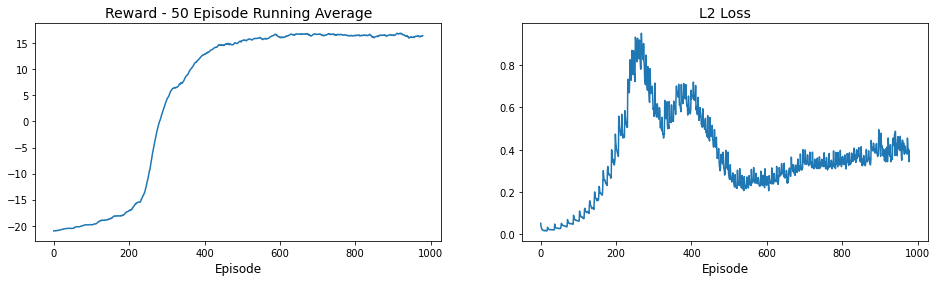

Episode: 979   Episode_score: 20.0   Epsilon: 0.050   Actions: [691 811]


In [4]:
for episode in range(1000):
    done = False
    reward_stat = 0
    screen = prepro(env.reset())
    state = np.dstack([screen, screen])
    next_state = state
    eps_state, eps_action, eps_next_state, eps_reward, eps_done = [],[],[],[],[]
    eps_loss = []
    while not done:
        step+=1
        state = np.expand_dims(state[:,:,1] - state[:,:,0], axis=2)
        action = select_action(state)
        reward = 0
        for _ in range(skip_frames):
            if done: break
            screen, r, done, _ = env.step(action+2)
            reward+=r
  
        next_state[:,:,0] = next_state[:,:,1]
        next_state[:,:,1] = prepro(screen)
        eps_state.append(state), eps_action.append(action), eps_reward.append(reward), eps_next_state.append(np.expand_dims(next_state[:,:,1] - next_state[:,:,0], axis=2)), eps_done.append(done)
        state = next_state
        reward_stat+=reward 
        if episode > 20 and step % 4 == 0: 
            loss_value, params, learner_state, target_params = update(step, params, learner_state, target_params, memory.sample(batch_size))
            eps_loss.append(loss_value)


    memory.push_episode([eps_state, eps_action, discounted_rewards(eps_reward), eps_next_state, eps_done])

    ############################################################################

    if episode > 20:
      running_rewards.append(0.98 * running_rewards[-1] + 0.02 * reward_stat)
      losses.append(np.mean(eps_loss))
      clear_output(wait=True) 
      figure, axis = plt.subplots(1, 2, sharex=True, figsize=(16,4))
      axis[0].plot(np.array(running_rewards))
      axis[0].set_title("Reward - 50 Episode Running Average", fontsize=14)
      axis[0].set_xlabel('Episode', fontsize=12)
      axis[1].plot(np.array(losses))
      axis[1].set_title("L2 Loss", fontsize=14)
      axis[1].set_xlabel('Episode', fontsize=12)
      plt.show() 
      print("Episode: {}   Episode_score: {}   Epsilon: {:.3f}   Actions: {}".format(episode-20, reward_stat, epsilon, np.bincount(eps_action)))


In [6]:
epsilon =0
epsilon_min = 0  
done = False
screen = prepro(env.reset())
state = np.dstack([screen, screen])
r1,r2  = 0,0
frames = []
scores = []
while not done:
    action = select_action(np.expand_dims(state[:,:,1]-state[:,:,0], axis=2))
    reward = 0
    for _ in range(skip_frames):
        if done: break
        screen, r, done, _ = env.step(action+2)
        reward+=r
    state[:,:,0] = state[:,:,1]
    state[:,:,1] = prepro(screen)
    frames.append(state[:,:,1]-state[:,:,0])
    if reward > 0: r1+=1
    elif reward < 0: r2+=1
    scores.append([r1,r2])

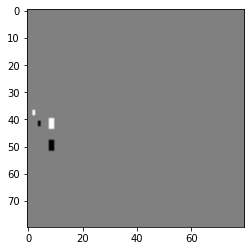

0 ------------------------------ 21


In [10]:
import time
for frame, score in zip(frames,scores):
    display.clear_output(wait=True)
    plt.imshow(frame, cmap='gray')
    plt.show()
    print(score[1],'-'*30,score[0])
    time.sleep(0.05)